<a href="https://colab.research.google.com/github/alviskagan/Twitter-Radicalism-Classification/blob/master/Twitter_Radikal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q PySastrawi
!pip install nltk
!pip install scikit-plot
!nltk.download()

/bin/bash: -c: line 1: syntax error: unexpected end of file


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import re
import seaborn as sns
import matplotlib.pyplot as plt

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import backend as K
from keras.initializers import Constant
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


Using TensorFlow backend.


# Pre-Processing

**Memuat data dari direktori Google Drive**

In [0]:
!fusermount -u drive
!google-drive-ocamlfuse drive

fusermount: failed to unmount /content/drive: No such file or directory
/bin/bash: google-drive-ocamlfuse: command not found


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
data = pd.read_csv("/gdrive/My Drive/LSTM Radikal/Development/radikal.csv", names = ['category','tweets'], sep =";")

**Memuat data dari lokal direktori**

In [0]:
# data = pd.read_csv("./radikal.csv", names = ['category','tweets'], sep =";")

**Melihat informasi data**

In [0]:
data.head()

,category,tweets
0,Radikal,Lah siapa ente kok mau melarang dakwah Agama A...
1,Radikal,Tujuan akhir adalah mati JIHAD!
2,Radikal,Makin beringas serangan musuh-musuh Allah. Mak...
3,Radikal,"Allah Akbar..Teruslah maju melangkah, sekalipu..."
4,Radikal,Islam Sejati Berani Mati


Text(0.5, 1.0, 'Number Radikal and Non')

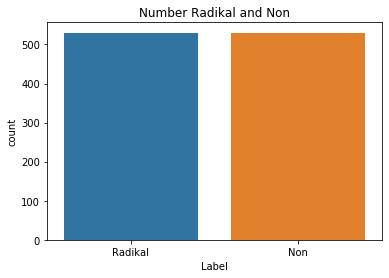

In [0]:
data.describe()
# data['category'][199]
sns.countplot(data.category)
plt.xlabel('Label')
plt.title('Number Radikal and Non')

**Proses casefolding, filtering dan stemming**

In [0]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [0]:
data['tweets'] = data['tweets'].astype(str) # Merubah tipe data tweets menjadi string
data['tweets'] = data['tweets'].apply(lambda x: x.lower()) # Prosess Casefolding
data['tweets'] = data['tweets'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # Prosess Filtering
data['tweets'] = data['tweets'].apply(lambda x: stemmer.stem(x)) # Prosess Stemming


In [0]:
# Menghitung jumlah data radikal dan non
print(data[ data['category'] == 'Radikal'].size)
print(data[ data['category'] == 'Non'].size)

1060
1060


In [0]:
# Menghilangkan kata rt pada tweets
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

In [0]:
data.head()

,category,tweets
0,Radikal,lah siapa ente kok mau larang dakwah agama all...
1,Radikal,tuju akhir adalah mati jihad
2,Radikal,makin beringas serang musuhmusuh allah makin d...
3,Radikal,allah akbarteruslah maju lang sekalipun banyak...
4,Radikal,islam sejati berani mati


In [0]:
# data.to_csv('/gdrive/My Drive/LSTM Radikal/Development/data_radikal_clean.csv')
# data = pd.read_csv("/gdrive/My Drive/LSTM Radikal/Development/data_radikal_clean.csv", index_col = None, sep =",")

In [0]:
# data.head()

In [0]:
# data_new = data.iloc[:,1:]

In [0]:
# data_new.head()

In [0]:
# data = data_new

In [0]:
# data.count()

**Proses model word2vec**

In [0]:
# !pip install -q nltk

In [0]:
# import string
# import gensim
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

In [0]:
# nltk.download("tokenize")

In [0]:
# tweet_lines = list()
# lines = data['tweets'].values.tolist()

In [0]:
# for line in lines:
#   line = stemmer.stem(line)
#   words = line.split()
#   print(words)
#   tweet_lines.append(words)


In [0]:
# print(tweet_lines[0])
# for line in tweet_lines:
#   print(line)

In [0]:
# model = gensim.models.Word2Vec(tweet_lines, size=100, window=5, min_count=1, workers=3)

In [0]:
# print(model)

In [0]:
# words = list(model.wv.vocab)

In [0]:
# print("Vocab size: " + str(len(words)))

In [0]:
# filename = "/gdrive/My Drive/LSTM Radikal/radikal_word2vec.txt"
# model.wv.save_word2vec_format(filename, binary = False)

In [0]:
import os
# filename = "/gdrive/My Drive/LSTM Radikal/radikal_word2vec.txt"
filename = "/gdrive/My Drive/LSTM Radikal/wiki_word2vec.txt"
embeddings_index = {}
f = open(os.path.join('',filename), encoding = "utf-8")

In [0]:
for line in f:
#   print(line)
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:])
  embeddings_index[word] = coefs
f.close()

**Proses Tokenisasi**

In [0]:
tokenizer = Tokenizer(num_words=1000, split=' ')
tokenizer.fit_on_texts(data['tweets'].values)
X = tokenizer.texts_to_sequences(data['tweets'].values)
word_index = tokenizer.word_index


X = pad_sequences(X)
print(X.shape)
print(X)
# data['category'].shape


(1060, 66)
[[252 136 300 ... 120 931  30]
 [  0   0   0 ...  25  83  13]
 [  0   0   0 ...   6 121 284]
 ...
 [  0   0   0 ...  50  39 651]
 [  0   0   0 ...  48 150  23]
 [  0   0   0 ... 174 117 883]]


**SMOTE**

In [0]:
# Y = pd.get_dummies(data['category']).values
# print(Y)

encoded_labels = [1 if label =='Radikal' else 0 for label in data['category']]
encoded_labels = np.array(encoded_labels)
print(encoded_labels[0:10])

y = to_categorical(encoded_labels, 2)
print(y)

[1 1 1 1 1 1 1 1 1 1]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix, classification_report

# split into 70:30 ration 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) 

# describes info about train and test set 
print("Number transactions X_train dataset: ", X_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions X_test dataset: ", X_test.shape) 
print("Number transactions y_test dataset: ", y_test.shape) 


Number transactions X_train dataset:  (742, 66)
Number transactions y_train dataset:  (742, 2)
Number transactions X_test dataset:  (318, 66)
Number transactions y_test dataset:  (318, 2)


In [0]:
# logistic regression object 
lr = LogisticRegression() 




In [0]:
# train the model on train set 
# lr.fit(X_train, y_train.ravel()) 

# predictions = lr.predict(X_test) 

# print classification report 
# print(classification_report(y_test, predictions)) 

**TfIdf** 

In [0]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import scikitplot.plotters as skplt

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [0]:
count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, max_features=None)    

tfidf = count_vectorizer.fit_transform(data['tweets'])

len(count_vectorizer.get_feature_names())
# print(tfidf)

4158

In [0]:
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds, figsize = (12,6), x_tick_rotation  = 20)

**Confussion Matrix**

In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 0.6068213470909936
Accuracy: 0.7028301886792453


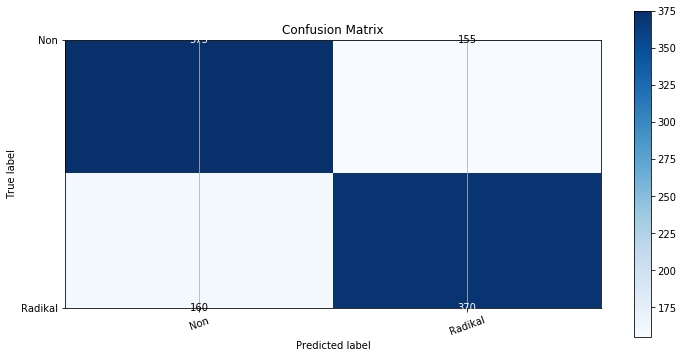

In [0]:
evaluate_features(truncated_tfidf, data['category'].values.ravel())

**Tf-Idf with Random Forest**

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 0.6141455380951837
Accuracy: 0.6783018867924528


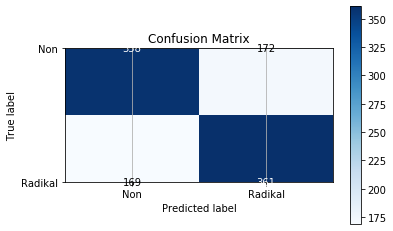

In [0]:
evaluate_features(truncated_tfidf,data['category'].values.ravel(),RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Log loss: 0.63874194564906
Accuracy: 0.7179245283018868


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


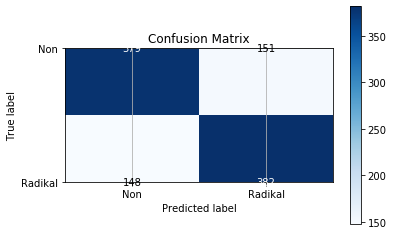

In [0]:
evaluate_features(truncated_tfidf,data['category'].values.ravel(),SVC(kernel='linear', probability=True))

# Training

**Fungsi untuk menampilkan hasil evaluasi menggunakan metric recall, precision, dan f1**

In [0]:
def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))


**Hyperparameter**

In [0]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
# print(vocab_size)
embed_dim = 100
lstm_out = 150
batch_size = 64
lr = 0.0001

**Embedding Matrix**

In [0]:
embedding_matrix = np.zeros((vocab_size, embed_dim))
for word, i in word_index.items():
  if i > vocab_size:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [0]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.11851173 -1.4863455  -0.31366915 ... -1.61981    -0.12239946
  -0.17125979]
 [-0.18721232 -0.10070437  2.4128578  ...  1.8376658   0.16101342
  -1.0679529 ]
 ...
 [-1.1407295   1.825817   -0.21033221 ...  2.0161612  -0.12878363
  -2.1062303 ]
 [ 0.6343693   1.1108342   0.1852357  ...  0.42759466 -1.0458143
   0.62767017]
 [-0.1815253   0.07731415  0.05116158 ...  0.11939284 -0.13380156
  -0.04658556]]


**Proses Modeling**

In [0]:
# Modeling data 2 layer LSTM
model = Sequential()
model.add(Embedding(vocab_size, embed_dim, embeddings_initializer = Constant(embedding_matrix), input_length = X.shape[1]))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(LSTM(lstm_out,return_sequences=True, activation = "relu"))
model.add(Dropout(0.4))

model.add(LSTM(lstm_out, activation = "relu"))
model.add(Dropout(0.4))
          
# model.add(Dense(100, activation = "sigmoid"))
# model.add(Dense(32, activation='sigmoid'))
# model.add(Dropout(0.2))

model.add(Dense(2, kernel_regularizer = regularizers.l2(0.1),activation='softmax'))
# model.add(Dense(2,activation='sigmoid'))
          
adam = keras.optimizers.Adam(lr=lr)
# model.compile(loss = 'binary_crossentropy', optimizer=adam,metrics = ['accuracy',recall_m, precision_m,f1_m])
model.compile(loss = 'binary_crossentropy', optimizer=adam,metrics = ['accuracy'])

print(model.summary())




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 66, 100)           415900    
_________________________________________________________________
lstm_1 (LSTM)                (None, 66, 150)           150600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 66, 150)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
______________________________________

**One hot-encode**

In [0]:
# Y = pd.get_dummies(data['category']).values
# print(Y)

encoded_labels = [1 if label =='Radikal' else 0 for label in data['category']]
encoded_labels = np.array(encoded_labels)
print(encoded_labels[0:10])

Y = to_categorical(encoded_labels, 2)
print(Y)

[1 1 1 1 1 1 1 1 1 1]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


**Memecah data menjadi data training dan data test**

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 40, shuffle = True)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(742, 66) (742, 2)
(318, 66) (318, 2)


# Cross Validation Test

In [0]:
from sklearn.model_selection import StratifiedKFold
import numpy

In [0]:
seed = 7
numpy.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
# print(kfold)


In [0]:
for train, test in kfold.split(data['tweets'], data['category']):
  # create model
  model = Sequential()
  model.add(Embedding(vocab_size, embed_dim, embeddings_initializer = Constant(embedding_matrix), input_length = X.shape[1]))
  model.add(LSTM(lstm_out,return_sequences=True, activation = "relu"))
  model.add(Dropout(0.4))
  model.add(LSTM(lstm_out, activation = "relu"))
  model.add(Dropout(0.4))
  model.add(Dense(2, kernel_regularizer = regularizers.l2(0.1),activation='softmax'))        
  # Compile model
  adam = keras.optimizers.Adam(lr=lr)
  model.compile(loss = 'binary_crossentropy', optimizer=adam,metrics = ['accuracy'])
  # Fit the model
  model.fit(X_train, Y_train, epochs = 100, batch_size=10, validation_data=(X_test,Y_test), verbose = 2)# evaluate the model
#   scores = model.evaluate(X_test, Y_test, verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))






Train on 742 samples, validate on 318 samples
Epoch 1/100





 - 15s - loss: 1.1019 - acc: 0.5040 - val_loss: 1.0581 - val_acc: 0.5535
Epoch 2/100
 - 13s - loss: 1.0367 - acc: 0.5984 - val_loss: 1.0058 - val_acc: 0.6792
Epoch 3/100
 - 13s - loss: 0.9773 - acc: 0.6819 - val_loss: 0.9404 - val_acc: 0.6887
Epoch 4/100
 - 13s - loss: 0.8960 - acc: 0.7089 - val_loss: 0.9256 - val_acc: 0.6981
Epoch 5/100
 - 14s - loss: 0.8576 - acc: 0.7251 - val_loss: 0.8643 - val_acc: 0.7201
Epoch 6/100
 - 13s - loss: 0.7975 - acc: 0.7615 - val_loss: 0.8908 - val_acc: 0.7138
Epoch 7/100
 - 13s - loss: 0.7400 - acc: 0.7776 - val_loss: 0.8336 - val_acc: 0.7421
Epoch 8/100
 - 14s - loss: 0.7133 - acc: 0.7817 - val_loss: 0.8082 - val_acc: 0.7201
Epoch 9/100
 - 13s - loss: 0.6573 - acc: 0.8113 - val_loss: 0.8197 - val_acc: 0.7138
Epoch 10/100
 - 12s - loss: 0.6155 - acc: 0.8261 - val_loss: 0.8585 - val_acc: 0.7296
Epoch 11/100
 - 13s - loss: 0.5610 - acc: 0.8558 - val_loss: 0.8800 - val_acc: 0.7170
Epoch 12/

KeyboardInterrupt: ignored

**Proses training model data**

In [0]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.1)
# result = model.fit(X_train, Y_train, epochs = 50, batch_size=batch_size, validation_split = 0.1, callbacks=[es], verbose = 2)
history = model.fit(X_train, Y_train, epochs = 50, batch_size=batch_size, validation_split = 0.33, verbose = 2)

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
# plt.plot(history.history['precision_m'])
# plt.plot(history.history['f1_m'])
# plt.plot(history.history['recall_m'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()


# plt.plot(history.history['precision_m'])
# plt.plot(history.history['f1_m'])
# plt.plot(history.history['recall_m'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['precision','f1','recall'],loc='upper left')
# plt.show()

# plt.hist(history.history['precision_m'])
# plt.bar(20,history.history['f1_m'])
# plt.bar(history.history['acc'],history.history['recall_m'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['precision'],loc='upper left')
# plt.show()

In [0]:
#  score = model.evaluate(X_test, Y_test, batch_size=64, verbose=2)

In [0]:
# print("Nilai akurasi: " + str(score[0]))
# print("Nilai loss: " + str(score[1]))
# print("Nilai recall: " + str(score[2]))
# print("Nilai precision: " + str(score[3]))
# print("Nilai f1: " + str(score[4]))

# plt.plot(history.history['precision_m'])
# plt.plot(history.history['f1_m'])
# plt.plot(history.history['recall_m'])
# plt.bar()
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['precision','f1','recall'],loc='upper left')
# plt.show()

In [0]:
probas = model.predict(X_test)


In [0]:
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)